In [1]:
# default_exp search

# Search

> Functions related to the search

This notebook contains all functions related to searching and getting peptide-spectrum-matches (PSMs). When searching, we compare how similar an experimental spectrum is to a theoretical spectrum. As described in the FASTA notebook, we can calculate theoretical fragment masses for a given peptide sequence and get theoretical spectra. Typically, we calculate a database with all possible spectra, save it to disk, and then compare our experimental data. This allows re-using the database and saving time for this computational step. It could be that the database is too large to be saved on disc; in this case, generate the database on the fly, referring to only have a subset of all FASTA entries in memory and processing them.

In [2]:
#hide
import warnings
from numba import NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

## Comparing spectra

To efficiently compare two spectra, we use a pointer based approach. We start with two sorted arrays, the `query_frag` that contains the m/z positions of the experimental query spectrum and the `db_frag` which contains the database fragment that is compared against to. The two pointers compare each m/z position with each other and check wheter they are within a certain tolerance `frag_tol`. Depending on their delta, either of the pointers is advanced. The function returns an arrray named `hits` that is the same length as the database spectrum and encodes the hit positions.

In [3]:
#export
import logging
from numba import njit
import numpy as np

@njit
def compare_frags(query_frag: np.ndarray, db_frag: np.ndarray, frag_tol: float, ppm:bool=False) -> np.ndarray:
    """Compare query and database frags and find hits

    Args:
        query_frag (np.ndarray): Array with query fragments.
        db_frag (np.ndarray): Array with database fragments.
        frag_tol (float): Fragment tolerance for search.
        ppm (bool, optional): Use ppm as unit or Dalton. Defaults to False.

    Returns:
        np.ndarray: Array with reported hits.
    """    
    q_max = len(query_frag)
    d_max = len(db_frag)
    hits = np.zeros(d_max, dtype=np.int16)
    q, d = 0, 0  # q > query, d > database
    while q < q_max and d < d_max:
        mass1 = query_frag[q]
        mass2 = db_frag[d]
        delta_mass = mass1 - mass2

        if ppm:
            sum_mass = mass1 + mass2
            mass_difference = 2 * delta_mass / sum_mass * 1e6
        else:
            mass_difference = delta_mass

        if abs(mass_difference) <= frag_tol:
            hits[d] = q + 1  # Save query position +1 (zero-indexing)
            d += 1
            q += 1  # Only one query for each db element
        elif delta_mass < 0:
            q += 1
        elif delta_mass > 0:
            d += 1

    return hits

In [4]:
import numpy as np
query_frag = np.array([100, 200, 300, 400])
db_frag = np.array([150, 200, 300, 450])

# Hits: Query 2 -> Db 2 and Query 3 -> Db 3

compare_frags(query_frag, db_frag, frag_tol=1)

array([0, 2, 3, 0], dtype=int16)

In [5]:
#hide
def test_compare_frags():
    query_frag = np.array([100, 200, 300, 400])
    frag_tol = 1

    db_frag = query_frag.copy()

    # Self-Comparison: no of hits should be same as length
    hits = compare_frags(query_frag, db_frag, frag_tol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: above but in tolerance
    hits = compare_frags(query_frag, db_frag + frag_tol - 0.01, frag_tol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: below but in tolerance
    hits = compare_frags(query_frag, db_frag - frag_tol + 0.01, frag_tol, ppm=False)
    assert np.sum(hits > 0) == len(query_frag)

    # Self-Comparison: above tolerance, no hits
    hits = compare_frags(query_frag, db_frag + frag_tol + 0.01, frag_tol, ppm=False)
    assert np.sum(hits > 0) == 0

    # Special case 1: First and last
    db_frag = np.array([100, 400])
    hits = compare_frags(query_frag, db_frag, frag_tol, ppm=False)
    assert np.sum(hits > 0) == 2

    # Special case 2: Two queries matching the same DB frag
    query_frag = np.array([100, 100.5])
    db_frag = np.array([100, 200, 300])
    hits = compare_frags(query_frag, db_frag, frag_tol, ppm=False)
    assert np.sum(hits > 0) == 1

    # Special case 3: Two db frags matching the same query frag
    db_frag = np.array([100, 100.5])
    query_frag = np.array([100, 200, 300])
    hits = compare_frags(query_frag, db_frag, frag_tol, ppm=False)
    assert np.sum(hits > 0) == 1
    
test_compare_frags()

This function allows us to easily compare a query spectrum against a spectrum from a theoretical database.

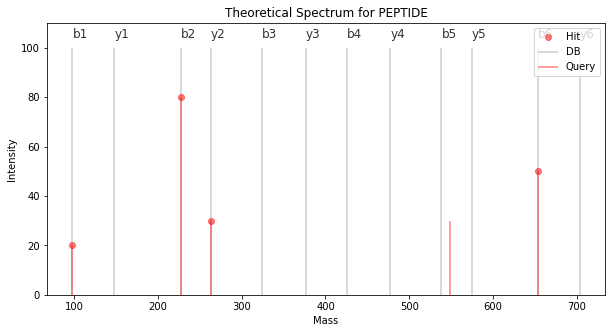

In [6]:
import matplotlib.pyplot as plt
from alphapept import constants
from alphapept.fasta import get_frag_dict, parse
import alphapept.io
import numpy as np

%matplotlib inline
peptide = 'PEPTIDE'

# Theoretical Spectrum

frag_dict = get_frag_dict(parse(peptide), constants.mass_dict)
db_frag = list(frag_dict.values())
db_frag.sort()

db_int = [100 for _ in db_frag]

# Experimental Spectrum, dummy data

query_frag = np.array([98.06, 227.10, 263.08, 548.06, 653.31])
query_int = np.array([20, 80, 30, 30, 50])

hits = compare_frags(query_frag, db_frag, frag_tol=1)

hitpos = hits[hits > 0] - 1
hit_x = query_frag[hitpos]
hit_y = query_int[hitpos]


plt.figure(figsize=(10,5))
plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)
plt.vlines(query_frag, 0, query_int, "r", label="Query", alpha=0.5)

plt.plot(hit_x, hit_y, "ro", label="Hit", alpha=0.5)

for _ in frag_dict.keys():
    plt.text(frag_dict[_], 104, _, fontsize=12, alpha = 0.8)
    
plt.title('Theoretical Spectrum for {}'.format(peptide))
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.legend()
plt.ylim([0,110])
plt.show()

## Comparing Spectra

To compare multiple spectra against a database, we first need some helper functions. First, we need a conversion function to convert from Dalton masses to ppm, which is implemented in the `ppm_to_dalton` function. 

To minimize the search space, we typically only compare spectra with precursors in the same mass range as defined by `prec_tol`. To look up the limits for search, we define the function `get_idxs`, which is a wrapper to the fast `searchsorted` method from `NumPy`.

The actual search takes place in `compare_spectrum_parallel`, which utilizes the performance decorator from the performance notebook. Here we save the top matching spectra for each query spectrum. Note that for code compilation reasons, the code of the previously defined function `compare_frags` is duplicated in here. 

In [7]:
#export

@njit
def ppm_to_dalton(mass:float, prec_tol:int)->float:
    """Function to convert ppm tolerances to Dalton.

    Args:
        mass (float): Base mass.
        prec_tol (int): Tolerance.

    Returns:
        float: Tolerance in Dalton.
    """    
    return mass / 1e6 * prec_tol

In [8]:
#hide

def test_ppm_to_dalton():
    assert ppm_to_dalton(200, 20) == 0.004
    
test_ppm_to_dalton()

In [9]:
#export

def get_idxs(db_masses:np.ndarray, query_masses:np.ndarray, prec_tol:float, ppm:bool)-> (np.ndarray, np.ndarray):
    """Function to get upper and lower limits to define search range for a given precursor tolerance.

    Args:
        db_masses (np.ndarray): Array containing database masses.
        query_masses (np.ndarray): Array containing query masses.
        prec_tol (float): Precursor tolerance for search.
        ppm: Flag to use ppm instead of Dalton.

    Returns:
        (np.ndarray, np.ndarray): Indices to lower and upper bounds.
    """    

    if ppm:
        dalton_offset = ppm_to_dalton(query_masses, prec_tol)
    else:
        dalton_offset = prec_tol

    idxs_lower = db_masses.searchsorted(query_masses - dalton_offset, side="left")
    idxs_higher = db_masses.searchsorted(query_masses + dalton_offset, side="right")

    return idxs_lower, idxs_higher

In [10]:
#hide
def test_get_idxs():
    idxs_lower, idxs_higher =  get_idxs(np.array([0,1,2,3]),np.array([1,2,3,4]), 10, True)

    assert np.allclose(idxs_lower, np.array([1, 2, 3, 4]))
    assert np.allclose(idxs_higher, np.array([2, 3, 4, 4]))
    
test_get_idxs()

In [11]:
#export

import alphapept.performance

@alphapept.performance.performance_function
def compare_spectrum_parallel(query_idx:int, query_masses:np.ndarray, idxs_lower:np.ndarray, idxs_higher:np.ndarray, query_indices:np.ndarray, query_frags:np.ndarray, query_ints:np.ndarray, db_indices:np.ndarray, db_frags:np.ndarray, best_hits:np.ndarray, score:np.ndarray, frag_tol:float, ppm:bool):
    """Compares a spectrum and writes to the best_hits and score.

    Args:
        query_idx (int): Integer to the query_spectrum that should be compared.
        query_masses (np.ndarray): Array with query masses.
        idxs_lower (np.ndarray): Array with indices for lower search boundary.
        idxs_higher (np.ndarray): Array with indices for upper search boundary.
        query_indices (np.ndarray): Array with indices to the query data.
        query_frags (np.ndarray): Array with frag types of the query data.
        query_ints (np.ndarray): Array with fragment intensities from the query.
        db_indices (np.ndarray):  Array with indices to the database data.
        db_frags (np.ndarray): Array with frag types of the db data.
        best_hits (np.ndarray): Reporting array which stores indices to the best hits.
        score (np.ndarray): Reporting array that stores the scores of the best hits.
        frag_tol (float): Fragment tolerance for search.
        ppm (bool): Flag to use ppm instead of Dalton.
    """    

    idx_low = idxs_lower[query_idx]
    idx_high = idxs_higher[query_idx]

    query_idx_start = query_indices[query_idx]
    query_idx_end = query_indices[query_idx + 1]
    query_frag = query_frags[query_idx_start:query_idx_end]
    query_int = query_ints[query_idx_start:query_idx_end]

    query_int_sum = 0
    for qi in query_int:
        query_int_sum += qi

    for db_idx in range(idx_low, idx_high):
        db_idx_start = db_indices[db_idx]
        db_idx_next = db_idx +1
        db_idx_end = db_indices[db_idx_next]

        db_frag = db_frags[db_idx_start:db_idx_end]

        q_max = len(query_frag)
        d_max = len(db_frag)

        hits = 0

        q, d = 0, 0  # q > query, d > database
        while q < q_max and d < d_max:
            mass1 = query_frag[q]
            mass2 = db_frag[d]
            delta_mass = mass1 - mass2

            if ppm:
                sum_mass = mass1 + mass2
                mass_difference = 2 * delta_mass / sum_mass * 1e6
            else:
                mass_difference = delta_mass

            if abs(mass_difference) <= frag_tol:
                hits += 1
                hits += query_int[q]/query_int_sum
                d += 1
                q += 1  # Only one query for each db element
            elif delta_mass < 0:
                q += 1
            elif delta_mass > 0:
                d += 1

        len_ = best_hits.shape[1]
        for i in range(len_):
            if score[query_idx, i] < hits:

                # This is mean to report the hit in our top-n array
                # The code below looks weird but is necessary to be used with cuda
                # It should be equivalent to this code:

                #score_slice = score[query_idx, i:(len_-1)]
                #hit_slice = best_hits[query_idx, i:(len_-1)]

                #score[query_idx, (i+1):len_] = score_slice
                #best_hits[query_idx, (i+1):len_] = hit_slice

                j = 1

                while len_-j >= (i+1):
                    k = len_-j
                    score[query_idx, k] = score[query_idx, k-1]
                    best_hits[query_idx, k] = best_hits[query_idx, k-1]
                    j+=1

                score[query_idx, i] = hits
                best_hits[query_idx, i] = db_idx
                break

In [12]:
#hide
def test_compare_spectrum_parallel():

    query_masses = np.array([300, 400, 500, 600])
    db_masses = np.array([300, 400, 500, 700])

    query_idxs = np.arange(len(query_masses))
    query_indices = np.array([4,8,12,16])
    query_frags = np.array([1,2,3,4]*4)

    query_ints = query_frags.copy()
    db_indices = query_indices.copy()
    db_frags = query_frags.copy()

    idxs_lower, idxs_higher =  get_idxs(db_masses, query_masses, 10, True)

    best_hits = np.zeros((len(query_masses), 5), dtype=np.int_)-1
    score = np.zeros((len(query_masses), 4), dtype=np.float_)

    frag_tol = 20
    ppm = True

    compare_spectrum_parallel(query_idxs, query_masses, idxs_lower, idxs_higher, query_indices, query_frags, query_ints, db_indices, db_frags, best_hits, score, frag_tol, ppm)

    query_idx, db_idx = np.where(score > 1)

    sortindex = np.argsort(query_idx)

    query_idx = query_idx[sortindex]
    db_idx = db_idx[sortindex]

    assert np.allclose(query_idx, np.array([0, 1, 2]))
    assert np.allclose(db_idx, np.array([0, 0, 0]))
    
#test_compare_spectrum_parallel() #TODO: this causes a bug in the CI

## Wrapper

To conveniently perform peptide-spectrum matches on multiple datasets we define a wrapper `get_psms` that returns the PSMS when handing over `query_data` and `db_data`.

In [13]:
#export

import pandas as pd
import logging
from alphapept.fasta import read_database

def query_data_to_features(query_data: dict)->pd.DataFrame:
    """Helper function to extract features from query data.
    This is used when the feature finder will not be used.

    Args:
        query_data (dict): Data structure containing the query data.

    Returns:
        pd.DataFrame: Pandas dataframe so that it can be used for subsequent processing.
    """    
    query_masses = query_data['prec_mass_list2']
    query_mz = query_data['mono_mzs2']
    query_rt = query_data['rt_list_ms2']

    features = pd.DataFrame(np.array([query_masses, query_mz, query_rt]).T, columns = ['mass_matched', 'mz_matched', 'rt_matched'])

    features['feature_idx'] = features.index #Index to query_data
    features['query_idx']  = np.arange(len(query_masses))

    features = features.sort_values('mass_matched', ascending=True)

    return features

In [14]:
#hide

def test_query_data_to_features():
    df = pd.DataFrame({'prec_mass_list2':[100,200,300], 'mono_mzs2':[100,200,300], 'rt_list_ms2':[1,2,3]})
    df_ = query_data_to_features(df)
    assert 'feature_idx' in df_.columns
    assert 'query_idx' in df_.columns
    
test_query_data_to_features()

In [15]:
#export
from typing import Callable

#this wrapper function is covered by the quick_test
def get_psms(
    query_data: dict,
    db_data: dict,
    features: pd.DataFrame,
    parallel: bool,
    frag_tol: float,
    prec_tol: float,
    ppm: bool,
    min_frag_hits: int,
    callback: Callable = None,
    prec_tol_calibrated:float = None,
    frag_tol_calibrated:float = None,
    **kwargs
)->(np.ndarray, int):
    """[summary]

    Args:
        query_data (dict): Data structure containing the query data.
        db_data (dict): Data structure containing the database data.
        features (pd.DataFrame): Pandas dataframe containing feature data.
        parallel (bool): Flag to use parallel processing.
        frag_tol (float): Fragment tolerance for search.
        prec_tol (float): Precursor tolerance for search.
        ppm (bool): Flag to use ppm instead of Dalton.
        min_frag_hits (int): Minimum number of frag hits to report a PSMs.
        callback (Callable, optional): Optional callback. Defaults to None.
        prec_tol_calibrated (float, optional): Precursor tolerance if calibration exists. Defaults to None.
        frag_tol_calibrated (float, optional): Fragment tolerance if calibration exists. Defaults to None.

    Returns:
        np.ndarray: Numpy recordarray storing the PSMs.
        int: 0
    """

    if isinstance(db_data, str):
        db_masses = read_database(db_data, array_name = 'precursors')
        db_frags = read_database(db_data, array_name = 'fragmasses')
        db_indices = read_database(db_data, array_name = 'indices')
    else:
        db_masses = db_data['precursors']
        db_frags = db_data['fragmasses']
        db_indices = db_data['indices']

    query_indices = query_data["indices_ms2"]
    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']
    
    if frag_tol_calibrated:
        frag_tol = frag_tol_calibrated
    
    if features is not None:
        if prec_tol_calibrated:
            prec_tol = prec_tol_calibrated
            query_masses = features['corrected_mass'].values
        else:
            query_masses = features['mass_matched'].values
        query_mz = features['mz_matched'].values
        query_rt = features['rt_matched'].values
        query_selection = features['query_idx'].values
        indices = np.zeros(len(query_selection) + 1, np.int64)
        indices[1:] = np.diff(query_indices)[query_selection]
        indices = np.cumsum(indices)
        query_frags = np.concatenate(
            [
                query_frags[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )

        query_ints = np.concatenate(
            [
                query_ints[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )
        query_indices = indices
    else:
        if prec_tol_calibrated:
            prec_tol = prec_tol_calibrated

        query_masses = query_data['prec_mass_list2']
        query_mz = query_data['mono_mzs2']
        query_rt = query_data['rt_list_ms2']

    idxs_lower, idxs_higher = get_idxs(
        db_masses,
        query_masses,
        prec_tol,
        ppm
    )

    n_queries = len(query_masses)
    n_db = len(db_masses)
    top_n = 5

    if alphapept.performance.COMPILATION_MODE == "cuda":
        import cupy
        cupy = cupy

        idxs_lower = cupy.array(idxs_lower)
        idxs_higher = cupy.array(idxs_higher)
        query_indices = cupy.array(query_indices)
        query_ints = cupy.array(query_ints)
        query_frags = cupy.array(query_frags)
        db_indices = cupy.array(db_indices)
        db_frags = cupy.array(db_frags)
        db_frags = cupy.array(db_frags)

    else:
        import numpy
        cupy = numpy

    best_hits = cupy.zeros((n_queries, top_n), dtype=cupy.int_)-1
    score = cupy.zeros((n_queries, top_n), dtype=cupy.float_)

    logging.info(f'Performing search on {n_queries:,} query and {n_db:,} db entries with frag_tol = {frag_tol:.2f} and prec_tol = {prec_tol:.2f}.')

    compare_spectrum_parallel(cupy.arange(n_queries), cupy.arange(n_queries), idxs_lower, idxs_higher, query_indices, query_frags, query_ints, db_indices, db_frags, best_hits, score, frag_tol, ppm)

    query_idx, db_idx_ = cupy.where(score > min_frag_hits)
    db_idx = best_hits[query_idx, db_idx_]
    score_ = score[query_idx, db_idx_]

    if cupy.__name__ != 'numpy':
        query_idx = query_idx.get()
        db_idx = db_idx.get()
        score_ = score_.get()

    psms = np.array(
        list(zip(query_idx, db_idx, score_)), dtype=[("query_idx", int), ("db_idx", int), ("hits", float)]
    )

    logging.info('Found {:,} psms.'.format(len(psms)))

    return psms, 0

## Extracting columns for scoring

The basic fragment comparison only counts the number of hits and matched intensity fraction when comparing a theoretical spectrum to an experimental one. Based on this metric, we can drastically reduce the number of candidates one wants to analyze for an in-depth comparison, which requires additional features. The following section describes several functions which extract parameters to compare spectrum matches better.

### Frag Delta

`frag_delta` substracts the experimental fragment masses from the theoretical fragment masses for each hit. 

In [16]:
#export
@njit
def frag_delta(query_frag:np.ndarray, db_frag:np.ndarray, hits:np.ndarray)-> (float, float):
    """Calculates the mass difference for a given array of hits in Dalton and ppm.

    Args:
        query_frag (np.ndarray): Array with query fragments.
        db_frag (np.ndarray): Array with database fragments.
        hits (np.ndarray): Array with reported hits.

    Returns:
        float: Fragment deltas in Dalton.
        float: Fragment deltas in ppm.
    """    
    delta_m = db_frag[hits > 0] - query_frag[hits[hits > 0] - 1]
    delta_m_ppm = (
        2 * delta_m / (db_frag[hits > 0] + query_frag[hits[hits > 0] - 1]) * 1e6
    )

    return delta_m, delta_m_ppm

In [17]:
#hide
def test_frag_delta():
    mtol = 10
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([101, 202, 303, 404])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    delta_m, delta_m_ppm = frag_delta(query_frag, db_frag, hits)

    assert np.sum(delta_m) == 10
    
test_frag_delta()

### Intensity Fraction
`intensity_fraction` calculates the fraction of matched intensity. This refers to the intensity of all hits compared to the intensity of all peaks in the query spectrum.

In [18]:
#export
@njit
def intensity_fraction(query_int:np.ndarray, hits:np.ndarray)->float:
    """Calculate the fraction of matched intensity

    Args:
        query_int (np.ndarray): Array with query intensities.
        hits (np.ndarray): Array with reported hits.

    Returns:
        float: Fraction of the matched intensity to the total intensity.
    """    

    total_intensity = np.sum(query_int)
    if total_intensity != 0:
        matched_intensity = np.sum(query_int[hits[hits > 0] - 1])
        i_frac = matched_intensity / total_intensity
    else:
        i_frac = 0

    return i_frac

In [19]:
#hide
def test_intensity_fraction():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])

    hits = compare_frags(query_frag, db_frag, mtol, ppm=False)
    i_frac = intensity_fraction(query_int, hits)

    assert i_frac == 40 / 100

test_intensity_fraction()

### File Format

To have an efficient data format to store PSMs in the search. We use `numpy`-recarrays and define the utility functions `add_column` and `remove_column` to append and remove data.

In [20]:
#export
from numpy.lib.recfunctions import append_fields, drop_fields


def add_column(recarray:np.ndarray, column:np.ndarray, name:str)->np.ndarray:
    """Function to add a column with given name to recarray

    Args:
        recarray (np.ndarray): NumPy record array.
        column (np.ndarray): Data column that should be added to the record array.
        name (str): Name of the column in the new recordarray.

    Returns:
        np.ndarray: NumPy recordarray with new field. 
    """
    if hasattr(recarray, name):
        recarray = drop_fields(recarray, name, usemask=False, asrecarray=True)
    recarray = append_fields(
        recarray, name, column, dtypes=column.dtype, usemask=False, asrecarray=True
    )
    return recarray


def remove_column(recarray:np.ndarray, name:str)->np.ndarray:
    """Function to remove a column from a recarray.

    Args:
        recarray (np.ndarray): NumPy record array.
        name (str): Column name of the column to be removed.

    Returns:
        np.ndarray: NumPy record array with removed column.
    """    
    if hasattr(recarray, name):
        recarray = drop_fields(recarray, name, usemask=False, asrecarray=True)
    return recarray

In [21]:
#hide

def test_rec_funs():
    x = np.array([1,2,3], dtype=[('x',float)])
    x_ = add_column(x, np.array([4,5,6]), 'y')
    assert np.allclose(x_['y'], np.array([4,5,6]))
    x__ = remove_column(x_, 'y')
    assert np.all(x == x__)
    
test_rec_funs()

## Extracting features for scoring

### Indices

When performing a database search, we need to know which experimental spectrum we compare with what database entry. 
We distinguish three indices:

* query_idx
* raw_idx
* feature_idx

Initially, the get_psms function accepts experimental data in the form of `query_data`. Here, the `query_idx` refers to the index to `query_data`. However, this might not be the same index as the raw data. This is due to the implementation of the matching of MS1-features to MS2 spectra. Here we allow multiple matches and implement this by repeating the respective spectrum. 

We then add the two columns `feature_idx` and `raw_idx` to the PSMs to later be able to distinguish where the match originated. In this case, `raw_idx` refers to the original spectrum.

When not applying feature finding, `raw_idx` and `query_idx` are equivalent.


### Features

In the `score`-function we use the pre-filtered PSMs to extract additional columns for scoring such as the offset from theoretical to experimental precursor or the number of b- and y-ion hits.

In [22]:
#export
from numba.typed import List
@njit
def get_hits(query_frag:np.ndarray, query_int:np.ndarray, db_frag:np.ndarray, db_int:np.ndarray, frag_type:np.ndarray, mtol:float, ppm:bool, losses:list)-> np.ndarray:
    """Function to extract the types of hits based on a single PSMs.

    The reporting array stores information about the matched ions column wise:

    Column 0: Type of the ion.
    Column 1: Ion-index refering to what ion type was matched.
    Column 2: Intensity of the matched ion.
    Column 3: Intensity of the database ion.
    Column 4: Experimental mass of the ion.
    Column 5: Theoretical mass of the ion.
    Column 6: Index to the query_frag of the ion.
    Column 7: Index to the database_frag of the ion.

    Args:
        query_frag (np.ndarray): Array with query fragments.
        query_int (np.ndarray): Array with query intensities.
        db_frag (np.ndarray): Array with database fragments.
        db_int (np.ndarray): Array with database intensities.
        frag_type (np.ndarray): Array with fragment types.
        mtol (float): Mass tolerance.
        ppm (bool): Flag to use ppm instead of Dalton.
        losses (list): List of losses.

    Returns:
        np.ndarray: NumPy array that stores ion information.
    """    
    max_array_size = len(db_frag)*len(losses)

    ions = np.zeros((max_array_size, 8))

    pointer = 0

    query_range = np.arange(len(query_frag))
    db_range = np.arange(len(db_frag))

    for idx, off in enumerate(losses):
        hits = compare_frags(query_frag, db_frag-off, mtol, ppm)
        n_hits = np.sum(hits>0)

        hitpos = hits[hits > 0] - 1
        hit = hits > 0

        ions[pointer:pointer+n_hits,0] = frag_type[hits>0] #type
        ions[pointer:pointer+n_hits,1] = idx #ion-index

        ions[pointer:pointer+n_hits,2] = query_int[hitpos] #query int
        ions[pointer:pointer+n_hits,3] = db_int[hit] #db int

        ions[pointer:pointer+n_hits,4] = query_frag[hitpos] #query mass
        ions[pointer:pointer+n_hits,5] = db_frag[hit]-off # db mass

        ions[pointer:pointer+n_hits,6] = query_range[hitpos] # index to query entry
        ions[pointer:pointer+n_hits,7] = db_range[hit] # index to db entry

        pointer += n_hits

    ions = ions[:pointer,:]

    return ions


In [23]:
#hide 
def test_get_hits():
    mtol = 1
    query_frag = np.array([100, 200, 300, 400])
    db_frag = np.array([100, 300, 500, 700])
    query_int = np.array([10, 20, 30, 40])
    db_int = np.array([10, 20, 30, 40])

    frag_type = np.array([1, -1, 1, -1])

    ppm = True
    losses = [0]

    ions = get_hits(query_frag, query_int, db_frag, db_int, frag_type, mtol, ppm, losses)

    assert ions[0,0] == 1.0
    assert ions[1,0] == -1.0

    assert ions[0,1] == 0
    assert ions[1,1] == 0

    assert ions[0,7] == 0
    assert ions[1,7] == 1

test_get_hits()

In [24]:
#export
from alphapept import constants
LOSS_DICT = constants.loss_dict
LOSSES = np.array(list(LOSS_DICT.values()))

#This function is a wrapper and ist tested by the quick_test
@njit
def score(
    psms: np.recarray,
    query_masses: np.ndarray,
    query_masses_raw: np.ndarray,
    query_frags: np.ndarray,
    query_ints: np.ndarray,
    query_indices: np.ndarray,
    db_masses: np.ndarray,
    db_frags: np.ndarray,
    frag_types: np.ndarray,
    mtol: float,
    db_indices: np.ndarray,
    ppm: bool,
    psms_dtype: list,
    db_ints: np.ndarray = None,
    parallel: bool = False
) -> (np.ndarray, np.ndarray):
    """Function to extract score columns when giving a recordarray with PSMs.

    Args:
        psms (np.recarray): Recordarray containing PSMs.
        query_masses (np.ndarray): Array with query masses.
        query_masses_raw (np.ndarray): Array with raw query masses.
        query_frags (np.ndarray): Array with frag types of the query data.
        query_ints (np.ndarray): Array with fragment intensities from the query.
        query_indices (np.ndarray): Array with indices to the query data.
        db_masses (np.ndarray): Array with database masses.
        db_frags (np.ndarray): Array with fragment masses.
        frag_types (np.ndarray): Array with fragment types.
        mtol (float): Mass tolerance.
        db_indices (np.ndarray): Array with indices to the database array.
        ppm (bool): Flag to use ppm instead of Dalton.
        psms_dtype (list): List describing the dtype of the PSMs record array.
        db_ints (np.ndarray, optional): Array with database intensities. Defaults to None.
        parallel (bool, optional): Flag to use parallel processing. Defaults to False.

    Returns:
        np.recarray: Recordarray containing PSMs with additional columns.
        np.ndarray: NumPy array containing ion information.
    """

    psms_ = np.zeros(len(psms), dtype=psms_dtype)

    ions_ = List()

    ion_count = 0

    for i in range(len(psms)):
        query_idx = psms[i]["query_idx"]
        db_idx = psms[i]["db_idx"]
        query_idx_start = query_indices[query_idx]
        query_idx_end = query_indices[query_idx + 1]
        query_frag = query_frags[query_idx_start:query_idx_end]
        query_int = query_ints[query_idx_start:query_idx_end]
        db_frag = db_frags[db_indices[db_idx]:db_indices[db_idx+1]]
        frag_type = frag_types[db_indices[db_idx]:db_indices[db_idx+1]]

        if db_ints is None:
            db_int = np.ones(len(db_frag))
        else:
            db_int = db_ints[i]

        ions = get_hits(query_frag, query_int, db_frag, db_int, frag_type, mtol, ppm, LOSSES)

        psms_['prec_offset'][i] = query_masses[query_idx] - db_masses[db_idx]
        psms_['prec_offset_ppm'][i] = 2 * psms_['prec_offset'][i] / (query_masses[query_idx]  + db_masses[db_idx] ) * 1e6

        psms_['prec_offset_raw '][i] = query_masses_raw[query_idx] - db_masses[db_idx]
        psms_['prec_offset_raw_ppm '][i] = 2 * psms_['prec_offset'][i] / (query_masses_raw[query_idx]  + db_masses[db_idx] ) * 1e6

        psms_['delta_m'][i] = np.mean(ions[:,4]-ions[:,5])
        psms_['delta_m_ppm'][i] = np.mean(2 * psms_['delta_m'][i] / (ions[:,4]  + ions[:,5] ) * 1e6)

        psms_['total_int'][i] = np.sum(query_int)
        psms_['matched_int'][i] = np.sum(ions[:,2])
        psms_['matched_int_ratio'][i] = psms_['matched_int'][i] / psms_['total_int'][i]
        psms_['int_ratio'][i] = np.mean(ions[:,2]/ions[:,3]) #3 is db_int, 2 is query_int

        psms_['b_hits'][i] = np.sum(ions[ions[:,1]==0][:,0]>0)
        psms_['y_hits'][i] = np.sum(ions[ions[:,1]==0][:,0]<0)

        psms_['b-H2O_hits'][i] = np.sum(ions[ions[:,1]==1][:,0]>0)
        psms_['y-H2O_hits'][i] = np.sum(ions[ions[:,1]==1][:,0]<0)

        psms_['b-NH3_hits'][i] = np.sum(ions[ions[:,1]==2][:,0]>0)
        psms_['y-NH3_hits'][i] = np.sum(ions[ions[:,1]==2][:,0]<0)

        n_ions = len(ions)

        psms_['n_ions'][i] = n_ions
        psms_['ion_idx'][i] = ion_count

        ion_count += n_ions
        ions_.append(ions)

    return psms_, ions_

In [25]:
#export

from numba.typed import Dict
def get_sequences(psms: np.recarray, db_seqs:np.ndarray)-> np.ndarray:
    """Get sequences to add them to a recarray

    Args:
        psms (np.recarray): Recordarray containing PSMs.
        db_seqs (np.ndarray): NumPy array containing sequences.

    Returns:
        np.ndarray: NumPy array containing a subset of sequences.
    """    
    sequence_list = db_seqs[psms["db_idx"]]

    return sequence_list

In [26]:
#hide
def test_get_sequences():
    x = np.array([(1.0, 2), (3, 4)], dtype=[('x', '<f8'), ('db_idx', '<i8')])
    db_seqs = np.array(['A','B','C','D','E'])
    assert list(get_sequences(x, db_seqs)) == ['C', 'E']
    
test_get_sequences()

In [27]:
#export
from typing import Union

#This function is a wrapper and ist tested by the quick_test
def get_score_columns(
    psms: np.recarray,
    query_data: dict,
    db_data: Union[dict, str],
    features: pd.DataFrame,
    parallel:bool,
    frag_tol:float,
    prec_tol:float,
    ppm:bool,
    prec_tol_calibrated:Union[None, float]=None,
    frag_tol_calibrated:float = None,
    **kwargs
) -> (np.ndarray, np.ndarray):
    """Wrapper function to extract score columns.

    Args:
        psms (np.recarray): Recordarray containing PSMs.
        query_data (dict): Data structure containing the query data.
        db_data: Union[dict, str]: Data structure containing the database data or path to database.
        features (pd.DataFrame): Pandas dataframe containing feature data.
        parallel (bool): Flag to use parallel processing.
        frag_tol (float): Fragment tolerance for search.
        prec_tol (float): Precursor tolerance for search.
        ppm (bool): Flag to use ppm instead of Dalton.
        prec_tol_calibrated (Union[None, float], optional): Calibrated offset mass. Defaults to None.
        frag_tol_calibrated (float, optional): Fragment tolerance if calibration exists. Defaults to None.

    Returns:
        np.recarray: Recordarray containing PSMs with additional columns.
        np.ndarray: NumPy array containing ion information.
    """
    logging.info('Extracting columns for scoring.')
    query_indices = query_data["indices_ms2"]
    query_charges = query_data['charge2']
    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']
    query_scans = query_data['scan_list_ms2']
    
    if frag_tol_calibrated:
        frag_tol = frag_tol_calibrated

    if 'prec_id2' in query_data.keys():
        bruker = True
        query_prec_id = query_data['prec_id2']
    else:
        bruker = False

    if isinstance(db_data, str):
        db_masses = read_database(db_data, array_name = 'precursors')
        db_frags = read_database(db_data, array_name = 'fragmasses')
        db_indices = read_database(db_data, array_name = 'indices')
        frag_types = read_database(db_data, array_name = 'fragtypes')

        try:
            db_ints = read_database(db_data, array_name = 'db_ints')
        except KeyError:
            db_ints = None

    else:
        db_masses = db_data['precursors']
        db_frags = db_data['fragmasses']
        db_indices = db_data['indices']
        frag_types = db_data['fragtypes']

        if 'db_ints' in db_data.keys():
            db_ints = db_data['db_ints']
        else:
            db_ints = None

    if features is not None:
        if prec_tol_calibrated:
            query_masses = features['corrected_mass'].values
        else:
            query_masses = features['mass_matched'].values

        query_masses_raw = features['mass_matched'].values

        query_mz = features['mz_matched'].values
        query_rt = features['rt_matched'].values
        query_charges = features['charge_matched'].values
        query_scans = query_scans[features['query_idx'].values]

        if bruker:
            query_prec_id = query_prec_id[features['query_idx'].values]

        query_selection = features['query_idx'].values
        indices = np.zeros(len(query_selection) + 1, np.int64)
        indices[1:] = np.diff(query_indices)[query_selection]
        indices = np.cumsum(indices)
        query_frags = np.concatenate(
            [
                query_frags[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )
        query_ints = np.concatenate(
            [
                query_ints[s: e] for s, e in zip(
                    query_indices[query_selection], query_indices[query_selection + 1]
                )
            ]
        )
        query_indices = indices
    else:
        #TODO: This code is outdated, callin with features = None will crash.
        query_masses = query_data['prec_mass_list2']
        query_masses_raw = query_data['prec_mass_list2']
        query_mz = query_data['mono_mzs2']
        query_rt = query_data['rt_list_ms2']

    float_fields = ['prec_offset', 'prec_offset_ppm', 'prec_offset_raw ','prec_offset_raw_ppm ','delta_m','delta_m_ppm','matched_int_ratio','int_ratio']
    int_fields = ['total_int','matched_int','n_ions','ion_idx'] + [a+_+'_hits' for _ in LOSS_DICT for a in ['b','y']]

    psms_dtype = np.dtype([(_,np.float32) for _ in float_fields] + [(_,np.int64) for _ in int_fields])

    psms_, ions,  = score(
        psms,
        query_masses,
        query_masses_raw,
        query_frags,
        query_ints,
        query_indices,
        db_masses,
        db_frags,
        frag_types,
        frag_tol,
        db_indices,
        ppm,
        psms_dtype)
    
    ions_ = np.vstack(ions)

    for _ in psms_.dtype.names:
        psms = add_column(psms, psms_[_], _)

    rts = np.array(query_rt)[psms["query_idx"]]
    psms = add_column(psms, rts, 'rt')

    if isinstance(db_data, str):
        db_seqs = read_database(db_data, array_name = 'seqs').astype(str)
    else:
        db_seqs = db_data['seqs']

    seqs = get_sequences(psms, db_seqs)

    del db_seqs

    psms = add_column(psms, seqs, "sequence")

    mass = np.array(query_masses)[psms["query_idx"]]
    mz = np.array(query_mz)[psms["query_idx"]]
    charge = np.array(query_charges)[psms["query_idx"]]

    psms = add_column(psms, mass, "mass")
    psms = add_column(psms, mz, "mz")
    psms = add_column(psms, charge, "charge")

    psms = add_column(psms, np.char.add(np.char.add(psms['sequence'],"_"), psms['charge'].astype(int).astype(str)), 'precursor')

    if features is not None:
        psms = add_column(psms, features.loc[psms['query_idx']]['feature_idx'].values, 'feature_idx')
        psms = add_column(psms, features.loc[psms['query_idx']]['query_idx'].values, 'raw_idx')

        for key in ['int_sum','int_apex','rt_start','rt_apex','rt_end','fwhm','dist','mobility']:
            if key in features.keys():
                psms = add_column(psms, features.loc[psms['query_idx']][key].values, key)

    scan_no = np.array(query_scans)[psms["query_idx"]]
    if bruker:
        psms = add_column(psms, scan_no, "parent")
        psms = add_column(psms, np.array(query_prec_id)[psms["query_idx"]], 'precursor_idx')
        psms = add_column(psms, psms['feature_idx']+1, 'feature_id') #Bruker
    else:
        psms = add_column(psms, scan_no, "scan_no")

    logging.info(f'Extracted columns from {len(psms):,} spectra.')

    return psms, ions_

## Plot

In [28]:
#export

import matplotlib.pyplot as plt

def plot_psms(index, ms_file):

    df = ms_file.read(dataset_name='peptide_fdr')
    
    ion_dict = {}
    ion_dict[0] = ''
    ion_dict[1] = '-H20'
    ion_dict[2] = '-NH3'

    spectrum = df.iloc[index]
    start = spectrum['ion_idx']
    end = spectrum['n_ions'] + start

    query_data = ms_file.read_DDA_query_data()
    ions = ms_file.read(dataset_name="ions")

    ion = [('b'+str(int(_))).replace('b-','y') for _ in ions.iloc[start:end]['ion_index']]
    losses = [ion_dict[int(_)] for _ in ions.iloc[start:end]['ion_type']]
    ion = [a+b for a,b in zip(ion, losses)]
    ints = ions.iloc[start:end]['ion_int'].astype('int').values
    masses = ions.iloc[start:end]['ion_mass'].astype('float').values
    ion_type = ions.iloc[start:end]['ion_type'].abs().values

    query_idx = spectrum['raw_idx']

    query_indices = query_data["indices_ms2"]
    query_charges = query_data['charge2']
    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']

    query_idx_start = query_indices[query_idx]
    query_idx_end = query_indices[query_idx + 1]
    query_frag = query_frags[query_idx_start:query_idx_end]
    query_int = query_ints[query_idx_start:query_idx_end]

    ax = plt.figure(figsize=(15, 5))

    plt.vlines(query_frag, 0, query_int, "k", label="Query", alpha=0.5)

    plt.vlines(masses, ints, max(query_int)*(1+0.1*ion_type), "k", label="Hits", alpha=0.5, linestyle=':')

    plt.vlines(masses, 0, ints, "r", label="Hits", alpha=0.5)

    for i in range(len(masses)):
        plt.text(masses[i], (1+0.1*ion_type[i])*max(query_int), ion[i])

    figure_title = f"{spectrum['precursor']} - b-hits {spectrum['b_hits']}, y-hits {spectrum['y_hits']}, matched int {spectrum['matched_int_ratio']*100:.2f} %"

    plt.xlabel("m/z")
    plt.ylabel('Intensity')
    plt.ylim([0, (1+0.1*max(ion_type)+0.1)*max(query_int)])
    plt.legend()
    plt.title(figure_title)
    plt.show()

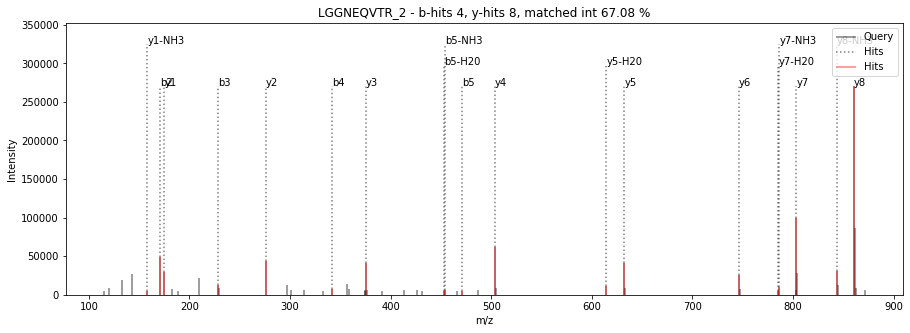

In [29]:
# Example usage to plot a psms
ms_file = alphapept.io.MS_Data_File('../testfiles/test.ms_data.hdf')
plot_psms(1, ms_file)

## Searching with database

We save intermediate results to hdf5 files

In [30]:
#export
import os
import pandas as pd
import copy
import alphapept.io
import alphapept.fasta
from typing import Callable

#This function is a wrapper and ist tested by the quick_test
def store_hdf(df: pd.DataFrame, path: str, key:str, replace:bool=False, swmr:bool = False):
    """Wrapper function to store a DataFrame in an hdf.

    Args:
        df (pd.DataFrame): DataFrame to be stored.
        path (str): Target path of the hdf file.
        key (str): Name of the field to be saved.
        replace (bool, optional): Flag whether the field should be replaced.. Defaults to False.
        swmr (bool, optional): Flag to use swmr(single write multiple read)-mode. Defaults to False.
    """    
    ms_file = alphapept.io.MS_Data_File(path.file_name, is_overwritable=True)

    if replace:
        ms_file.write(df, dataset_name=key, swmr = swmr)
    else:
        try:
            df.to_hdf(path, key=key, append=True)
            #TODO, append is not implemented yet
        except (ValueError, AttributeError):
            try:
                old_df = ms_file.read(dataset_name=key, swmr = swmr)
                new_df = pd.concat([old_df, df])
                ms_file.write(new_df, dataset_name=key, swmr = swmr)
            except KeyError: # File is created new
                ms_file.write(df, dataset_name=key, swmr = swmr)

#This function is a wrapper and ist tested by the quick_test
def search_db(to_process:tuple, callback:Callable = None, parallel:bool=False, first_search:bool = True) -> Union[bool, str]:
    """Wrapper function to perform database search to be used by a parallel pool.

    Args:
        to_process (tuple): Tuple containing an index to the file and the experiment settings.
        callback (Callable, optional): Callback function to indicate progress. Defaults to None.
        parallel (bool, optional): Flag to use parallel processing. Defaults to False.
        first_search (bool, optional): Flag to indicate this is the first search. Defaults to True.

    Returns:
        Union[bool, str]: Returns True if the search was successfull, otherwise returns a string containing the Exception.
    """    

    try:
        index, settings = to_process
        file_name = settings['experiment']['file_paths'][index]
        base_file_name, ext = os.path.splitext(file_name)
        ms_file = base_file_name+".ms_data.hdf"

        skip = False
        feature_calibration = False

        ms_file_ = alphapept.io.MS_Data_File(
            f"{ms_file}"
        )

        if not first_search:
            try:
                calibration = float(ms_file_.read(group_name = 'features', dataset_name='corrected_mass', attr_name='estimated_max_precursor_ppm'))
                if calibration == 0:
                    logging.info('Calibration is 0, skipping second database search.')
                    skip = True
                else:
                    settings['search']['prec_tol_calibrated'] = calibration*settings['search']['calibration_std']
                    calib = settings['search']['prec_tol_calibrated']
                    logging.info(f"Found calibrated prec_tol with value {calib:.2f}")
            except KeyError as e:
                logging.info(f'{e}')

            try:
                fragment_std = float(ms_file_.read(dataset_name="estimated_max_fragment_ppm")[0])
                skip = False 
                settings['search']['frag_tol_calibrated'] = fragment_std*settings['search']['calibration_std']
                calib = settings['search']['frag_tol_calibrated']
                logging.info(f"Found calibrated frag_tol with value {calib:.2f}")
            except KeyError as e:
                logging.info(f'{e}')                
     
        if not skip:
            db_data_path = settings['experiment']['database_path']

    #         TODO calibrated_fragments should be included in settings
            query_data = ms_file_.read_DDA_query_data(
                calibrated_fragments=True,
                database_file_name=settings['experiment']['database_path']
            )

            features = ms_file_.read(dataset_name="features")

            psms, num_specs_compared = get_psms(query_data, db_data_path, features, **settings["search"])
            if len(psms) > 0:
                psms, ions = get_score_columns(psms, query_data, db_data_path, features, **settings["search"])

                if first_search:
                    logging.info('Saving first_search results to {}'.format(ms_file))
                    save_field = 'first_search'
                else:
                    logging.info('Saving second_search results to {}'.format(ms_file))
                    save_field = 'second_search'

                store_hdf(pd.DataFrame(psms), ms_file_, save_field, replace=True)
                ion_columns = ['ion_index','ion_type','ion_int','db_int','ion_mass','db_mass','query_idx','db_idx']
                store_hdf(pd.DataFrame(ions, columns = ion_columns), ms_file_, 'ions', replace=True)
            else:
                logging.info('No psms found.')

        logging.info(f'Search of file {file_name} complete.')
        return True
    except Exception as e:
        logging.error(f'Search of file {file_name} failed. Exception {e}.')
        return f"{e}" #Can't return exception object, cast as string

## Searching Large Fasta and or Search Space

In [31]:
#export

from alphapept.fasta import blocks, generate_peptides, add_to_pept_dict
from alphapept.io import list_to_numpy_f32
from alphapept.fasta import block_idx, generate_fasta_list, generate_spectra, check_peptide
from alphapept import constants
mass_dict = constants.mass_dict
import os
import alphapept.performance

#This function is a wrapper and ist tested by the quick_test
def search_fasta_block(to_process:tuple) -> (list, int):
    """Search fasta block. This file digests per block and does not use a saved database.
    For searches with big fasta files or unspecific searches.

    Args:
        to_process (tuple): Tuple containing a fasta_index, fasta_block, a list of files and a list of experimental settings.

    Returns:
        list: A list of dataframes when searching the respective file.
        int: Number of new peptides that were generated in this iteration.
    """   


    fasta_index, fasta_block, ms_files, settings = to_process

    settings_ = settings[0]
    spectra_block = settings_['fasta']['spectra_block']
    to_add = List()

    psms_container = [list() for _ in ms_files]

    f_index = 0

    pept_dict = {}
    for element in fasta_block:
        sequence = element["sequence"]
        mod_peptides = generate_peptides(sequence, **settings_['fasta'])

        pept_dict, added_peptides = add_to_pept_dict(pept_dict, mod_peptides, fasta_index+f_index)

        if len(added_peptides) > 0:
            to_add.extend(added_peptides)

        f_index += 1


    if len(to_add) > 0:
        for seq_block in blocks(to_add, spectra_block):

            spectra = generate_spectra(seq_block, mass_dict)

            precmasses, seqs, fragmasses, fragtypes = zip(*spectra)
            sortindex = np.argsort(precmasses)

            fragmasses = np.array(fragmasses, dtype=object)[sortindex]
            fragtypes = np.array(fragtypes, dtype=object)[sortindex]

            lens = [len(_) for _ in fragmasses]

            n_frags = sum(lens)

            frags = np.zeros(n_frags, dtype=fragmasses[0].dtype)
            frag_types = np.zeros(n_frags, dtype=fragtypes[0].dtype)

            indices = np.zeros(len(lens) + 1, np.int64)
            indices[1:] = lens
            indices = np.cumsum(indices)

            #Fill data

            for _ in range(len(indices)-1):
                start = indices[_]
                end = indices[_+1]
                frags[start:end] = fragmasses[_]
                frag_types[start:end] = fragtypes[_]

            db_data = {}

            db_data["precursors"] = np.array(precmasses)[sortindex]
            db_data["seqs"] = np.array(seqs)[sortindex]

            db_data["fragmasses"] = frags
            db_data["fragtypes"] = frag_types
            db_data["indices"] = indices

            for file_idx, ms_file in enumerate(ms_files):
                query_data = alphapept.io.MS_Data_File(
                    f"{ms_file}"
                ).read_DDA_query_data(swmr=True)

                try:
                    features = alphapept.io.MS_Data_File(
                        ms_file
                    ).read(dataset_name="features",swmr=True)
                except FileNotFoundError:
                    features = None
                except KeyError:
                    features = None

                psms, num_specs_compared = get_psms(query_data, db_data, features, **settings[file_idx]["search"])

                if len(psms) > 0:
                    #This could be speed up..
                    psms, ions = get_score_columns(psms, query_data, db_data, features, **settings[file_idx]["search"])

                    fasta_indices = [set(x for x in pept_dict[_]) for _ in psms['sequence']]

                    psms_df = pd.DataFrame(psms)
                    psms_df['fasta_index'] = fasta_indices

                    psms_container[file_idx].append(psms_df)

    return psms_container, len(to_add)

In [32]:
#export

def filter_top_n(temp:pd.DataFrame, top_n:int = 10)-> pd.DataFrame:
    """Takes a dataframe and keeps only the top n entries (based on hits).
    Combines fasta indices for sequences.

    Args:
        temp (pd.DataFrame): Pandas DataFrame containing PSMs.
        top_n (int, optional): Number of top-n entries to be kept. Defaults to 10.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """    
    pept_dict_ = {}
    
    temp['temp_idx'] = np.arange(len(temp))

    for k, v in temp[['sequence','fasta_index']].values:
        if k in pept_dict_:
            new_set = pept_dict_[k]
            if isinstance(v, set):
                new_set.update(v)
            else:
                new_set.add(v)
            pept_dict_[k] = new_set
        else:
            pept_dict_[k] = set(v)

    temp['fasta_index'] = [pept_dict_[_] for _ in temp['sequence']]
    temp = temp.drop_duplicates(subset = ['raw_idx','sequence','hits','feature_idx'])
    temp = temp.sort_values('hits', ascending = False).groupby('raw_idx').head(top_n)

    return temp


In [33]:
#hide

def test_filter_top_n():
    test_df = pd.DataFrame({'sequence':['A','A','A','A','A'],
                            'fasta_index':[{1},{2},{3},{4},{5}],
                            'hits':[1,2,3,4,5],
                            'feature_idx':[1,2,3,4,5],
                            'raw_idx':[1,1,1,1,1]})

    filtered = filter_top_n(test_df, 3)

    assert len(filtered) == 3
    assert np.allclose(filtered['hits'].values, np.array([5, 4, 3]))

test_filter_top_n()

In [34]:
#export
import psutil
import alphapept.constants as constants
from alphapept.fasta import get_fragmass, parse

def ion_extractor(df: pd.DataFrame, ms_file, frag_tol:float, ppm:bool)->(np.ndarray, np.ndarray):
    """Extracts the matched hits (ions) from a dataframe.

    Args:
        df (pd.DataFrame): Pandas dataframe containing the results of the first search.
        ms_file : MsFile
        frag_tol (float): Fragment tolerance for search.
        ppm (bool): Flag to use ppm instead of Dalton.

    Returns:
        np.ndarray: Numpy recordarray storing the PSMs.
        np.ndarray: Numpy recordarray storing the ions.
    """

    query_data = ms_file.read_DDA_query_data()
    query_indices = query_data["indices_ms2"]
    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']
    
    psms = df.to_records()
    
    ion_count = 0
    
    ions_ = List()

    for i in range(len(psms)):
        query_idx = psms[i]["raw_idx"]
        db_idx = psms[i]["db_idx"]
        query_idx_start = query_indices[query_idx]
        query_idx_end = query_indices[query_idx + 1]
        query_frag = query_frags[query_idx_start:query_idx_end]
        query_int = query_ints[query_idx_start:query_idx_end]

        seq = psms[i]['sequence']

        db_frag, frag_type = get_fragmass(parse(seq), constants.mass_dict)
        db_int = np.ones_like(db_frag)

        ions = get_hits(query_frag, query_int, db_frag, db_int, frag_type, frag_tol, ppm, LOSSES)

        n_ions = len(ions)

        psms['n_ions'][i] = n_ions
        psms['ion_idx'][i] = ion_count

        ion_count += n_ions
        ions_.append(ions)
        
    ions_ = np.vstack(ions_)

    return psms, ions_


#This function is a wrapper and ist tested by the quick_test
def search_parallel(settings: dict, calibration:Union[list, None] = None, fragment_calibration:Union[list, None] = None, callback: Union[Callable, None] = None) -> dict:
    """Function to search multiple ms_data files in parallel.
    This function will additionally calculate fragments and precursor masses from a given FASTA file.

    Args:
        settings (dict): Settings file containg the experimental definitions.
        calibration (Union[list, None], optional): List of calibrated offsets. Defaults to None.
        fragment_calibration (Union[list, None], optional): List of calibrated fragment offsets. Defaults to None.
        callback (Union[Callable, None], optional): Callback function. Defaults to None.

    Returns:
        dict: FASTA dictionary.
    """    
    fasta_list, fasta_dict = generate_fasta_list(fasta_paths = settings['experiment']['fasta_paths'], **settings['fasta'])

    fasta_block = settings['fasta']['fasta_block']

    ms_file_path = []

    for _ in settings['experiment']['file_paths']:
        base, ext = os.path.splitext(_)
        ms_file_path.append(base + '.ms_data.hdf')

    if calibration:
        custom_settings = []
        for _ in calibration:
            settings_ = copy.deepcopy(settings)
            settings_["search"]["prec_tol_calibrated"] = _
            custom_settings.append(settings_)
    else:
        custom_settings = [settings for _ in ms_file_path]

    if fragment_calibration:
        for idx, _ in enumerate(fragment_calibration):
            custom_settings[idx]["search"]["frag_tol_calibrated"] = _
        
        
    logging.info(f"Number of FASTA entries: {len(fasta_list):,} - FASTA settings {settings['fasta']}")
    to_process = [(idx_start, fasta_list[idx_start:idx_end], ms_file_path, custom_settings) for idx_start, idx_end in block_idx(len(fasta_list), fasta_block)]

    memory_available = psutil.virtual_memory().available/1024**3

    n_processes = int(memory_available // 4 )
    
    logging.info(f'Setting Process limit to {n_processes}')
        
    n_processes = alphapept.performance.set_worker_count(
        worker_count=n_processes,
        set_global=False
    )

    n_seqs_ = 0

    df_cache = {} 
    ion_cache = {}
                
    with alphapept.performance.AlphaPool(n_processes) as p:
        max_ = len(to_process)

        for i, (psm_container, n_seqs) in enumerate(p.imap_unordered(search_fasta_block, to_process)):
            n_seqs_ += n_seqs

            logging.info(f'Block {i+1} of {max_} complete - {((i+1)/max_*100):.2f} % - created peptides {n_seqs:,} ')
            for j in range(len(psm_container)): #Temporary hdf files for avoiding saving issues
                output = [_ for _ in psm_container[j]]
                if len(output) > 0:
                    psms = pd.concat(output)
                    if ms_file_path[j] in df_cache:
                        temp = filter_top_n(pd.concat([df_cache[ms_file_path[j]], psms]))
                        selector = temp['temp_idx'].values
                        df_cache[ms_file_path[j]] = temp
                    else:
                        df_cache[ms_file_path[j]] = psms
                                                     
            if callback:
                callback((i+1)/max_)

    for idx, _ in enumerate(ms_file_path):
        if _ in df_cache:
            x = df_cache[_]
            ms_file = alphapept.io.MS_Data_File(_)

            x['fasta_index'] = x['fasta_index'].apply(lambda x: ','.join(str(_) for _ in x))
            
            
            if 'frag_tol_calibrated' in custom_settings[idx]['search']:
                frag_tol = custom_settings[idx]['search']['frag_tol_calibrated']
            else:
                frag_tol = custom_settings[idx]['search']['frag_tol']
                
            ppm = custom_settings[idx]['search']['ppm']
            
            if calibration:
                save_field = 'first_search'
            else:
                save_field = 'second_search'
                
            psms, ions = ion_extractor(x, ms_file, frag_tol, ppm)

            store_hdf(pd.DataFrame(psms), ms_file, save_field, replace=True)
            ion_columns = ['ion_index','ion_type','ion_int','db_int','ion_mass','db_mass','query_idx','db_idx']
            store_hdf(pd.DataFrame(ions, columns = ion_columns), ms_file, 'ions', replace=True)
            
    #Todo? Callback
    logging.info(f'Complete. Created peptides {n_seqs_:,}')

    return fasta_dict

In [35]:
#hide
from nbdev.showdoc import *

In [36]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_settings.ipynb.
Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_interface.ipynb.
Converted 12_performance.ipynb.
Converted 13_export.ipynb.
Converted 14_display.ipynb.
Converted 15_label.ipynb.
Converted additional_code.ipynb.
Converted contributing.ipynb.
Converted file_formats.ipynb.
Converted index.ipynb.
